## *Data Mining*

#### *Data Mining is the process of `discovering patterns`, `relationships`, and useful insights from large sets of data. It’s like finding valuable information hidden in a big pile of data*

### *Importing Libraries*

In [1]:
import warnings
import numpy as np
import pandas as pd
from IPython.display import display  
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns  
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_parquet('../data/final/olist_full_data_Loaded.parquet', engine='pyarrow')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,estimated_delay,order_processing_time,recency_days,purchase_frequency,monetary_value,product_volume_cm3,product_density,category_review_score,is_late,high_freight_flag
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149.0,...,-8,0.0,335,2,82.82,1976.0,0.25,4.09,0,0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149.0,...,-8,0.0,335,2,82.82,1976.0,0.25,4.09,0,0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149.0,...,-8,0.0,335,2,82.82,1976.0,0.25,4.09,0,0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813.0,...,-6,1.0,40,1,141.46,4693.0,0.09,4.16,0,1
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265.0,...,-18,0.0,26,1,179.12,9576.0,0.04,4.09,0,0


## *1.Clustering (Unsupervised Learning)*

### *K-Means*:
*Clustering is an unsupervised machine learning technique used to group similar data points together into clusters — where each group shares more similarities with each other than with those in other groups.*

##### *Step 1:Choose Relevant Columns for Clustering*
*Since K-Means works only with numerical values, we need to pick columns that are:Meaningful for identifying groups of similar orders or customers*
- *Numerical*



In [3]:
features_to_cluster = ['price','freight_value','payment_installments','payment_value', 'review_score', 'product_weight_g', 'product_volume_cm3', 'product_density','profit_margin',
                        'freight_ratio','order_processing_time','recency_days','purchase_frequency','monetary_value']
df_cluster = df[features_to_cluster].copy()

| *Feature*                  | *Meaning*                               | *Cluster Interpretation Example*                        |
|----------------------------|------------------------------------------|----------------------------------------------------------|
| *price, payment_value*     | *How much was paid*                      | *High vs. low spenders*                                  |
| *freight_value*            | *Shipping cost*                          | *Far-distance orders vs. nearby*                         |
| *payment_installments*     | *Payment flexibility*                    | *Installment buyers vs. full-payers*                     |
| *review_score*             | *Customer satisfaction*                  | *Happy vs. unhappy buyers*                               |
| *product_weight_g*         | *Weight of items*                        | *Heavy vs. light product buyers*                         |
| *product_volume_cm3*       | *Size of products*                       | *Bulky vs. compact items*                                |
| *product_density*          | *Weight-to-size ratio*                   | *Dense items vs. fluffy ones*                            |
| *profit_margin*            | *Seller profit*                          | *High-profit vs. low-profit orders*                      |
| *freight_ratio*            | *Shipping cost compared to price*        | *Expensive-to-ship vs. cheap-to-ship items*              |
| *order_processing_time*    | *Days taken to process*                  | *Fast vs. slow fulfillment*                              |
| *recency_days*             | *Days since last purchase*               | *Recent vs. old customers*                               |
| *purchase_frequency*       | *How often the customer buys*            | *Frequent vs. rare buyers*                               |
| *monetary_value*           | *Total money spent by customer*          | *High-value vs. low-value customers*                     |


#### *Step 2: Handling Missing Values*

In [4]:
df_cluster.isnull().sum()

price                     0
freight_value             0
payment_installments      0
payment_value             0
review_score              0
product_weight_g          0
product_volume_cm3        0
product_density           0
profit_margin             0
freight_ratio             0
order_processing_time    15
recency_days              0
purchase_frequency        0
monetary_value            0
dtype: int64

In [5]:
# Check if there are any inf or -inf values
print(np.isinf(df_cluster).sum())

price                    0
freight_value            0
payment_installments     0
payment_value            0
review_score             0
product_weight_g         0
product_volume_cm3       0
product_density          0
profit_margin            0
freight_ratio            5
order_processing_time    0
recency_days             0
purchase_frequency       0
monetary_value           0
dtype: int64


In [6]:
# Replace inf and very large values with NaN
df_cluster['freight_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_cluster.loc[df_cluster['freight_ratio'].abs() > 1e308, 'freight_ratio'] = np.nan

In [7]:
df_cluster.dropna(subset=['freight_ratio', 'order_processing_time'], inplace=True)

### *Step 3: Scaling the Data*
*K-Means is distance-based, so we must scale all features so that one with large values (e.g., monetary_value) doesn't dominate the clustering.*


---

In [8]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

### *StandardScaler* from `sklearn.preprocessing`

`StandardScaler` standardizes features by *removing the mean* and *scaling to unit variance*.

---

### *Mathematically*, it transforms each feature like this:

$$
z = \frac{x - \mu}{\sigma}
$$

Where:

* *$x$* = *original value*
* *$\mu$* = *mean of the feature column*
* *$\sigma$* = *standard deviation*
* *$z$* = *standardized (scaled) value*

---

### This ensures:

* *Each column has mean = 0*
* *Each column has standard deviation = 1*

---

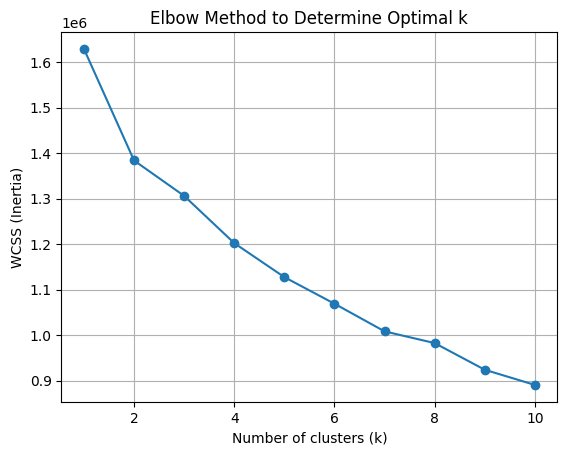

In [9]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()

### Plot Trends

| k  | Inertia | Pattern                          |
|----|---------|----------------------------------|
| 2  | 1.6     | *High inertia (poor fit)*        |
| 4  | 1.3     | *Sharp drop (~18.75% decrease)*  |
| 6  | 1.1     | *Slower drop (~15.4% decrease)*  |
| 8  | 1.0     | *Minimal drop (~9.1% decrease)*  |
| 10 | 0.9     | *Plateau (~10% decrease)*        |

---

### **Elbow Method: Summary Interpretation**

#### **Key Inertia Trends**

* **k = 2 → 4**: Inertia drops from 1.6 to 1.3 (*\~18.75% drop*)
  → *Strong improvement; likely 4 natural clusters*

* **k = 4 → 6**: Drops to 1.1 (*\~15.4% drop*)
  → *Moderate gain; substructure may exist*

* **k = 6 → 10**: Flattens to 0.9
  → *Marginal gains; risk of overfitting*

---

### **Optimal k Recommendation**

* **Best Choice: k = 4**
  → *Captures main structure with minimal complexity*

* **Alternative: k = 6**
  → *Consider if domain knowledge supports subgroups*

* **Avoid: k > 6**
  → *Gains are minimal, interpretability decreases*

---


### *Elbow Method to Choose k*

#### *Choosing and Applying Final k*

In [10]:
final_k = 4
kmeans = KMeans(n_clusters=final_k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(scaled_data)

In [11]:
df_cluster.groupby('cluster').mean(numeric_only=True).round(2)

,price,freight_value,payment_installments,payment_value,review_score,product_weight_g,product_volume_cm3,product_density,profit_margin,freight_ratio,order_processing_time,recency_days,purchase_frequency,monetary_value
cluster,,,,,,,,,,,,,,
0,88.99,17.34,2.37,128.58,3.99,1135.49,9388.46,0.17,111.24,0.35,0.29,143.22,1.10,252.03
1,106.13,17.29,3.44,148.11,4.21,1495.60,12564.62,0.18,130.82,0.43,0.23,399.35,1.07,281.95
2,1053.00,48.60,6.16,1726.00,3.60,6669.55,38487.21,0.56,1677.40,0.03,0.47,235.21,1.12,7454.16
3,274.64,50.49,4.63,373.11,3.88,12317.62,73146.16,0.32,322.62,0.76,0.29,238.28,1.07,667.22


In [12]:
# Step 1: Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_components_2d = pca.fit_transform(scaled_data)

# Calculate variance explained
variance = pca.explained_variance_ratio_
cumulative_variance = variance.cumsum()

In [13]:
# variance output
for i, (var, cum) in enumerate(zip(variance, cumulative_variance), start=1):
    print(f"PC{i}: Explained Variance = {var:.2%}, Cumulative = {cum:.2%}")


PC1: Explained Variance = 27.31%, Cumulative = 27.31%
PC2: Explained Variance = 12.92%, Cumulative = 40.23%


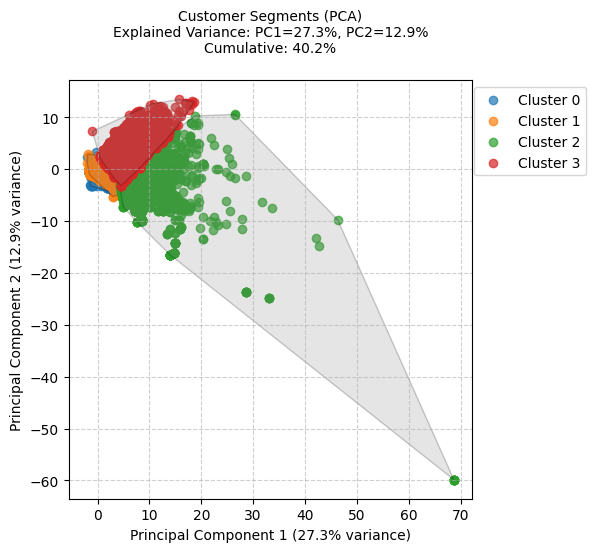

In [14]:


# Step 2: Create figure
plt.figure(figsize=(6, 6))

# Step 3: Scatter and convex hulls for each cluster
for cluster in np.unique(df_cluster['cluster']):
    points = pca_components_2d[df_cluster['cluster'] == cluster]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster}", alpha=0.7)

    if len(points) >= 3:  # At least 3 points for 2D convex hull
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        polygon = Polygon(hull_points, alpha=0.2, edgecolor='black', facecolor='gray')
        plt.gca().add_patch(polygon)



        
# Annotations and styling
plt.title(
    f'Customer Segments (PCA)\n'
    f'Explained Variance: PC1={variance[0]:.1%}, PC2={variance[1]:.1%}\n'
    f'Cumulative: {cumulative_variance[1]:.1%}',
    fontsize=10,
    pad=20
)
plt.xlabel(f'Principal Component 1 ({variance[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({variance[1]:.1%} variance)')

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))


# Equal aspect ratio to preserve distances
plt.gca().set_aspect('equal')

plt.tight_layout()

In [15]:
# Step 1: Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_components_2d = pca.fit_transform(scaled_data)

# Calculate variance explained
variance = pca.explained_variance_ratio_
cumulative_variance = variance.cumsum()

PC1: Explained Variance = 27.31%, Cumulative = 27.31%
PC2: Explained Variance = 12.92%, Cumulative = 40.23%


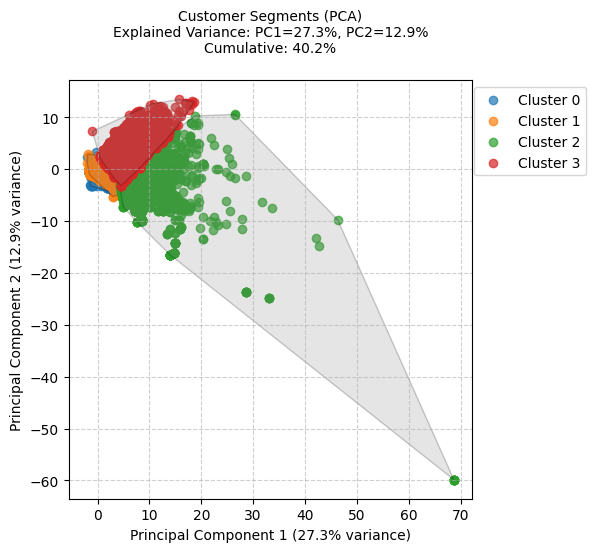

In [16]:
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

# Step 2: Create figure
plt.figure(figsize=(6, 6))

# Step 3: Scatter and convex hulls for each cluster
for cluster in np.unique(df_cluster['cluster']):
    points = pca_components_2d[df_cluster['cluster'] == cluster]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster}", alpha=0.7)

    if len(points) >= 3:  # At least 3 points for 2D convex hull
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        polygon = Polygon(hull_points, alpha=0.2, edgecolor='black', facecolor='gray')
        plt.gca().add_patch(polygon)



        
# Annotations and styling
plt.title(
    f'Customer Segments (PCA)\n'
    f'Explained Variance: PC1={variance[0]:.1%}, PC2={variance[1]:.1%}\n'
    f'Cumulative: {cumulative_variance[1]:.1%}',
    fontsize=10,
    pad=20
)
plt.xlabel(f'Principal Component 1 ({variance[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({variance[1]:.1%} variance)')

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))


# Equal aspect ratio to preserve distances
plt.gca().set_aspect('equal')

plt.tight_layout()

# variance output
for i, (var, cum) in enumerate(zip(variance, cumulative_variance), start=1):
    print(f"PC{i}: Explained Variance = {var:.2%}, Cumulative = {cum:.2%}")


In [ ]:
# from sklearn.metrics import silhouette_score
# print(f"Silhouette Scgitore: {silhouette_score(scaled_data, df_cluster['cluster']):.2f}")

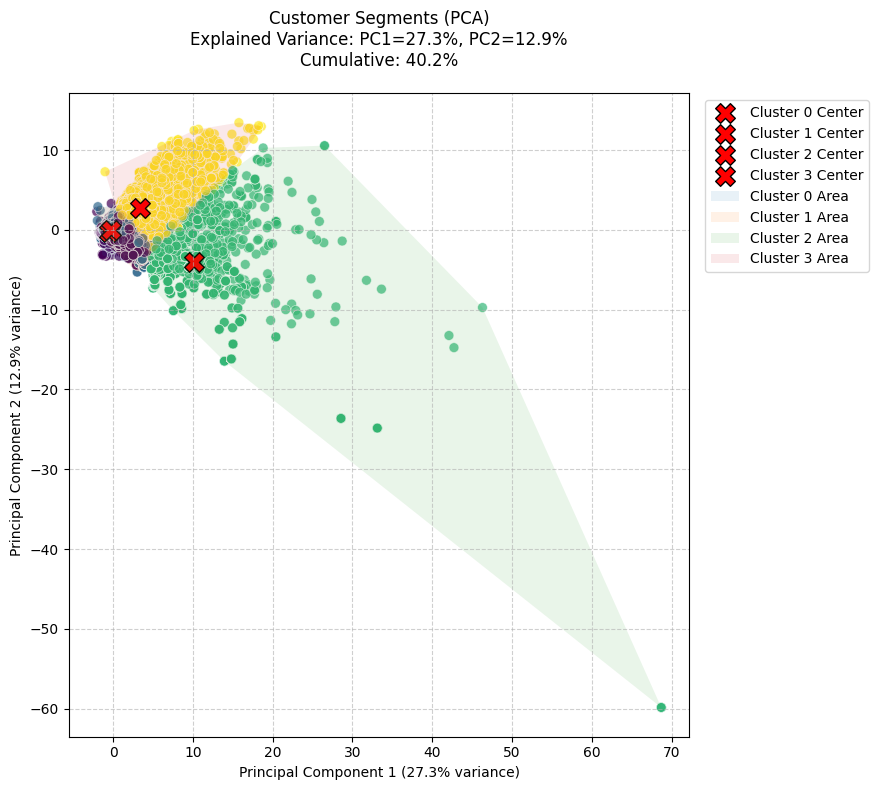

In [18]:
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Calculate variance explained
variance = pca.explained_variance_ratio_
cumulative_variance = variance.cumsum()

# Set up the plot
plt.figure(figsize=(10, 8))

# Scatter plot with clusters
scatter = plt.scatter(
    pca_components[:, 0], 
    pca_components[:, 1], 
    c=df_cluster['cluster'], 
    cmap='viridis',  # More perceptually uniform than tab10
    alpha=0.7,
    s=50,           # Larger points
    edgecolor='w',  # White borders for clarity
    linewidth=0.5
)

# Add cluster centroids
centroids = []
for cluster in np.unique(df_cluster['cluster']):
    centroid = pca_components[df_cluster['cluster'] == cluster].mean(axis=0)
    plt.scatter(
        centroid[0], 
        centroid[1],
        marker='X',
        s=200,
        c='red',
        edgecolor='black',
        label=f'Cluster {cluster} Center'
    )
    centroids.append(centroid)

# Add convex hulls for each cluster (optional)
from scipy.spatial import ConvexHull
for cluster in np.unique(df_cluster['cluster']):
    points = pca_components[df_cluster['cluster'] == cluster]
    if len(points) >= 3:  # Need at least 3 points for a hull
        hull = ConvexHull(points)
        plt.fill(
            points[hull.vertices, 0], 
            points[hull.vertices, 1],
            alpha=0.1,
            label=f'Cluster {cluster} Area'
        )

# Annotations and styling
plt.title(
    f'Customer Segments (PCA)\n'
    f'Explained Variance: PC1={variance[0]:.1%}, PC2={variance[1]:.1%}\n'
    f'Cumulative: {cumulative_variance[1]:.1%}',
    fontsize=12,
    pad=20
)
plt.xlabel(f'Principal Component 1 ({variance[0]:.1%} variance)')
plt.ylabel(f'Principal Component 2 ({variance[1]:.1%} variance)')

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))


# Equal aspect ratio to preserve distances
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()